In [73]:
# coding: utf-8
import logging
import os

import geopandas as gpd
import numpy as np
import pandas as pd
import powerplantmatching as pm
import pypsa
import xarray as xr
#from _helpers import configure_logging, getContinent, update_p_nom_max, pdbcast
from shapely.validation import make_valid
from shapely.geometry import Point
from vresutils import transfer as vtransfer

idx = pd.IndexSlice

In [70]:
import yaml
with open("../config.yaml", 'r') as stream:
    try:
        snakemake_config=yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [251]:
n= pypsa.Network('../results/version-0.6/networks/original_27-supply_redz_lcopt_LC.nc')


INFO:pypsa.io:Imported network original_27-supply_redz_lcopt_LC.nc has buses, carriers, generators, lines, loads, storage_units


In [252]:
n.generators.p_nom_opt

Generator
Kendal                    3840.0
Lethabo                   3540.0
MajubaDry                 1830.0
MajubaWet                 2010.0
Matimba                   3720.0
                         ...    
HIGHVELD SOUTH load    1000000.0
HIGHVELD NORTH load    1000000.0
LOWVELD load           1000000.0
NEWCASTLE load         1000000.0
EMPANGENI load         1000000.0
Name: p_nom_opt, Length: 69, dtype: float64

In [253]:
n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

carrier
CCGT       1.234523e+04
OCGT       5.321261e+03
coal       2.334900e+04
load       2.700000e+07
nuclear    1.860000e+03
onwind     5.294692e+04
solar      3.213143e+04
Name: p_nom_opt, dtype: float64

In [241]:
n.storage_units.p_nom_opt.groupby(n.storage_units.carrier).sum()

carrier
PHS        2912.00000
battery    8622.68256
hydro      2165.00000
Name: p_nom_opt, dtype: float64

<AxesSubplot:xlabel='snapshot'>

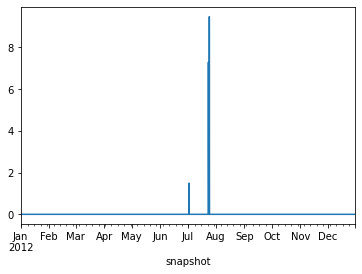

In [258]:
n.generators_t.p['KAROO load'].plot()

In [221]:
n.storage_units.capital_cost

StorageUnit
Drakensberg      2.010000e+05
Ingula           2.530000e+06
Palmiet          2.010000e+05
Gariep           0.000000e+00
Vanderkloof      0.000000e+00
ColleyWobbles    0.000000e+00
Steenbras        0.000000e+00
CahoraBassa      0.000000e+00
RSA battery      1.522227e+06
Name: capital_cost, dtype: float64

In [147]:
n.generators.loc['RSA coal',:]

Owner                                
carrier                          coal
p_nom                             0.0
y                                 NaN
x                                 NaN
efficiency                      0.464
marginal_cost              376.747027
capital_cost            2094704.43397
ramp_limit_up                     NaN
bus                               RSA
p_nom_extendable                 True
p_nom_max                         inf
control                            PQ
sign                              1.0
p_nom_opt                         0.0
type                                 
p_nom_min                         0.0
p_min_pu                          0.0
p_max_pu                          1.0
p_set                             0.0
q_set                             0.0
build_year                          0
lifetime                          inf
committable                     False
start_up_cost                     0.0
shut_down_cost                    0.0
min_up_time 

In [247]:
n= pypsa.Network('../results/version-0.5/networks/csir-aggressive_redz_E_LC_27-supply.nc')

INFO:pypsa.io:Imported network csir-aggressive_redz_E_LC_27-supply.nc has buses, carriers, generators, lines, loads, storage_units


In [250]:
n.generators.loc['JOHANNESBURG Load']

,Owner,carrier,p_nom,y,x,efficiency,marginal_cost,capital_cost,ramp_limit_up,bus,...,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
Kendal,Eskom,Coal,3840.0,-26.08805,28.96888,0.306305,2.756163e+02,594000.0,0.028125,HIGHVELD NORTH,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Lethabo,Eskom,Coal,3540.0,-26.74027,27.97500,0.328018,1.799293e+02,594000.0,0.100000,VAAL TRIANGLE,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaDry,Eskom,Coal,1830.0,-27.09555,29.77055,0.306305,3.132249e+02,594000.0,0.055738,NEWCASTLE,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaWet,Eskom,Coal,2010.0,-27.09555,29.77055,0.327154,3.134030e+02,594000.0,0.056716,NEWCASTLE,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Matimba,Eskom,Coal,3720.0,-23.66777,27.61277,0.308907,1.898651e+02,594000.0,0.048387,WATERBERG,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HIGHVELD SOUTH Load,,load,1000000.0,NaN,NaN,1.000000,1.563000e+06,0.0,NaN,HIGHVELD SOUTH,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
HIGHVELD NORTH Load,,load,1000000.0,NaN,NaN,1.000000,1.563000e+06,0.0,NaN,HIGHVELD NORTH,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
LOWVELD Load,,load,1000000.0,NaN,NaN,1.000000,1.563000e+06,0.0,NaN,LOWVELD,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0


In [228]:
n.storage_units.efficiency_dispatch

StorageUnit
Drakensberg      0.858487
Ingula           0.883176
Palmiet          0.882610
Gariep           1.000000
Vanderkloof      1.000000
ColleyWobbles    1.000000
Steenbras        0.848528
CahoraBassa      1.000000
RSA battery      0.943398
Name: efficiency_dispatch, dtype: float64